# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode

# Create Reinforcement Learning Environment

In [2]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environoments
    visualization::Bool # visualization
    realtime::Bool # realtime
    
    # Everything you need aditionaly can also go in here.
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    ω_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    Δt::T # Δ time
    
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    norm_way::T
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T # tolerance within drones has to reach waypoint
    projected_position::Vector{T} # projected position of drone along trajectory

    slow_mode::Bool # slow flight learning mode
end

In [3]:
R_TOL = 1.0;
N_WAYPOINTS = 8;
SLOW_MODE = true;

In [4]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments 
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.

    
    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            # orientate yourself on the state space from the paper
            typemin(T)..typemax(T), # position along x
            typemin(T)..typemax(T), # position along z
            
            typemin(T)..typemax(T), # orientation along x
            typemin(T)..typemax(T), # orientation along z
            
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along y BODY coordinates
            
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # position error along x (next gate - current position)
            typemin(T)..typemax(T), # position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # way to next next gate z (next next gate - next gate)
            # TODO: more points?
            ], 
    )
    
    num_waypoints = N_WAYPOINTS # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints) # trajectory with num_waypoints waypoints (+ start point) 
    reached_goal = falses(num_waypoints)
    
    norm_way = 0.0 
    for i in 1:(num_waypoints - 1)
        norm_way += norm(waypoints[i] - waypoints[i + 1])
    end
    
    if visualization #visualizes VTOL and waypoints
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
        visualize_waypoints(waypoints, 0.15)
    end

    environment = VtolEnv(
        action_space,
        state_space, 
        zeros(T, length(state_space)), # current state, needs to be extended
        rand(action_space), #initialization action
        false, # episode done 
        0.0, # time
        rng, # random number generator  
        
        name,
        visualization,
        realtime,
        
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation, Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # Δt 
        
        num_waypoints, # includig start point
        waypoints, 
        reached_goal,
        
        norm_way, # norm_way
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        R_TOL, # r_tol
        zeros(T, 3), # projected_position

        SLOW_MODE # slow_mode
    )
    
    
    reset!(environment)
    
    return environment
    
end;

# Define the RL interface

In [5]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [6]:
function scale_for_slowmode(slow_mode::Bool, v_min::T, v_max::T, d_max::T, x_W::Vector{T}, projected_position::Vector{T}, v_B::Vector{T}) where T
    # TODO safe in utils
    if slow_mode == false
        return 1
    else
        if norm(v_B) > v_max
            s_vmax = 10^(v_max - norm(v_B))
        else
            s_vmax = 1
        end

        if norm(v_B) < v_min
            s_vmin = 10^(norm(v_B) - v_min)
        else
            s_vmin = 1
        end

        if norm(x_W - projected_position) > d_max
            s_gd = exp(-norm(x_W - projected_position) + d_max)
        else
            s_gd = 1
        end
        s = s_vmax * s_vmin * s_gd
    end
    return s
end;

In [7]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    v_min = 4.0 # min velocity
    v_max = 50.0 # max velocity
    d_max = 0.50 


    s = scale_for_slowmode(env.slow_mode, v_min, v_max, d_max, env.x_W, env.projected_position, env.v_B)
    
    # Todo norm weg? 
    k_p = 5.0 * s / env.norm_way #env.num_waypoints / env.norm_way;# factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    k_s = s * (2 * v_max * env.Δt) / (env.norm_way^2) #5.0 # factor for reached distance (overall) reward
    r_s = env.progress # reward for reached distance (overall)
    
    k_wp = 10.0 # * env.num_waypoints # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end 

    k_ω = 0.001 # factor for too high body rate penalty
    norm_ω = norm(env.ω_B[3]) # penalty for body rate

    if env.x_W[3] < -2
        fall = 1
    else
        fall = 0
    end

    return k_p * r_p + k_s * r_s + k_wp * r_wp - k_ω * norm_ω - fall
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [8]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));

    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];
    
    #env.num_waypoints = 4; # includig start point
    env.waypoints = generate_trajectory(env.num_waypoints);
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    #env.r_tol = 0.3;
    
    if env.visualization
        visualize_waypoints(env.waypoints, 0.15); 
    end
    
    norm_way = 0.0 
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end
    
    env.norm_way = norm_way
    env.progress = 0.0;
    env.progress_prev = 0.0;
    
    
    env.state = [env.x_W[1]; # position along x
                 env.x_W[3]; # position along z
        
                 env.R_W[1,1]; # orientation along x
                 env.R_W[3,1]; # orientation along z
        
                 env.v_B[1]; # velocity along x BODY coordinates
                 env.v_B[2]; # velocity along y BODY coordinates  
        
                 env.ω_B[3]; # rotational velocity along z BODY coordinates
        
                 env.waypoints[2][1] - env.x_W[1]; # position error to next gate along x
                 env.waypoints[2][3] - env.x_W[3]; # position error to next gate along z
                 
                 0.0; # way to next next gate x 
                 2.0] # way to next next gate z 
    
    if env.num_waypoints >= 3
        env.state[10] = env.waypoints[3][1] - env.x_W[1]; # way to next next gate x 
        env.state[11] = env.waypoints[3][3] - env.x_W[3]; # way to next next gate z 
    end
        
    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;

    env.projected_position = [0; 0; 0]
    
    nothing

end;

In [9]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # TODO: set flaps later in 3D
    # set the propeller trust and the two flaps 2D case
    next_action = [a[1], a[2], 0.0, 0.0]
   
    _step!(env, next_action)
end

In [10]:
function _step!(env::VtolEnv, next_action)
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);
    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0; torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0; env.ω_B[2] = 0.0;
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param)
    
    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
            
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, env.projected_position = calculate_progress(env.waypoints, env.x_W)
    
    #env.current_point = line_segment + 1

    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - env.projected_position)
    
    env.progress = current_progress
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state 
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action)
        
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.2, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end
    end
 

    env.t += env.Δt
    
    env.state[1] = env.x_W[1]; # position along x
    env.state[2] = env.x_W[3]; # position along z
    
    env.state[3] = env.R_W[1,1]; # orientation along x
    env.state[4] = env.R_W[3,1]; # orientation along z
    
    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates
    
    env.state[7] = env.ω_B[3];  # rotational velocity along z BODY coordinates
    
    # TODO add points
    if env.current_point <= env.num_waypoints
        env.state[8] = env.waypoints[env.current_point][1] - env.x_W[1]; # position error along x
        env.state[9] = env.waypoints[env.current_point][3] - env.x_W[3]; # position error along z
        
        if env.current_point <= env.num_waypoints - 1
            env.state[10] = env.waypoints[env.current_point + 1][1] - env.x_W[1]; # way to next next gate x (next next gate - next gate)
            env.state[11] = env.waypoints[env.current_point + 1][3] - env.x_W[3]; # way to next next gate z (next next gate - next gate)
        else
            env.state[10] = env.state[8] + 0.0 # way to next next gate x (next next gate - next gate)
            env.state[11] = env.state[9] + 2.0 # way to next next gate z (next next gate - next gate)
        end
    else
        env.state[8] = 0.0; # position error along x
        env.state[9] = 2.0; # position error along z
        env.state[10] = 0.0 # way to next next gate x (next next gate - next gate)
        env.state[11] = 2.0 # way to next next gate z (next next gate - next gate)
    end
        
    
    # Termination criteria
    # TODO: Use many termination criteria so that you do not train unnecessarily in wrong areas
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 100.0 || 
        norm(env.v_B) > 100.0 || # stop if body is too fast_point
        env.x_W[3] < -5.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 3.0 ||# stop after 3s per point
        norm(env.x_W - env.projected_position) > 5.0 || # too far off the path 
        env.reached_goal == trues(env.num_waypoints)

    nothing
end;

# Setup of a reinforcement learning experiment.

In [11]:
seed = 123    
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024
test_env = VtolEnv(;name = "testVTOL");

In [12]:
# Define the function approximator
# TODO: change architecture eventually, smaller?
    ns, na = length(state(test_env)), length(action_space(test_env))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),#
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

In [13]:
    agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # TODO: change eventually to SAC or compare
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /home/larissa/.julia/packages/Flux/7nTyc/src/functor.jl:187


In [14]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./RL_models_fast/", "vtol_2D_ppo_$t.bson") # TODO: evtl anpassen
    @save f model
    println("parameters at step $t saved to $f")
end;

In [15]:
function loadModel(path, num)
    f = joinpath(path, "vtol_2D_ppo_$num.bson") # TODO: evtl anpassen
    @load f model
    return model
end;

In [39]:
function validate(num_models, num_test)
    episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
    # create a env only for reward test
    
    
    rewards = zeros(num_models,1);
    success_rate = zeros(num_models,1);
    avg_velocity = zeros(num_models,1);
    
    for i in 1:num_models
        
        
        sum_rewards_model = 0;
        sum_successes_model = 0;
        sum_avg_vel_model = 0;
        n_success = 0;
        
        for exp in 1:num_test
            RLBase.reset!(test_env)
            agent.policy.approximator = loadModel("./RL_models_fast/", i*10000); # TODO: change to desired
            run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
            # the result of the hook
            sum_rewards_model += episode_test_reward_hook.rewards[end];
            
            if test_env.reached_goal == trues(test_env.num_waypoints)
                n_success += 1
                sum_avg_vel_model += test_env.norm_way / test_env.t
            end
        end
        
        rewards[i] = sum_rewards_model / num_test;
        success_rate[i] = n_success / num_test;
        if n_success > 0
            avg_velocity[i] = sum_avg_vel_model / n_success;
        else
            avg_velocity[i] = NaN
        end
        percent = percent = round(i * 100 / num_models, digits=2)
        println("progress: $(percent)%")
    end
    
    return rewards, success_rate, avg_velocity
end;

In [44]:
num_model = 70
num_test = 1000

rewards, success_rate, avg_velocity = validate(num_model, num_test)

progress: 1.43%
progress: 2.86%
progress: 4.29%
progress: 5.71%
progress: 7.14%
progress: 8.57%
progress: 10.0%
progress: 11.43%
progress: 12.86%
progress: 14.29%
progress: 15.71%
progress: 17.14%
progress: 18.57%
progress: 20.0%
progress: 21.43%
progress: 22.86%
progress: 24.29%
progress: 25.71%
progress: 27.14%
progress: 28.57%
progress: 30.0%
progress: 31.43%
progress: 32.86%
progress: 34.29%
progress: 35.71%
progress: 37.14%
progress: 38.57%
progress: 40.0%
progress: 41.43%
progress: 42.86%
progress: 44.29%
progress: 45.71%
progress: 47.14%
progress: 48.57%
progress: 50.0%
progress: 51.43%
progress: 52.86%
progress: 54.29%
progress: 55.71%
progress: 57.14%
progress: 58.57%
progress: 60.0%
progress: 61.43%
progress: 62.86%
progress: 64.29%
progress: 65.71%
progress: 67.14%
progress: 68.57%
progress: 70.0%
progress: 71.43%
progress: 72.86%
progress: 74.29%
progress: 75.71%
progress: 77.14%
progress: 78.57%
progress: 80.0%
progress: 81.43%
progress: 82.86%
progress: 84.29%
progress: 8

([25.285962834524003; 31.120849498308846; … ; 32.04686019786216; 32.60253394676327;;], [0.184; 0.442; … ; 0.648; 0.675;;], [2.5619579172924207; 2.7816219068409374; … ; 4.863894149801665; 4.758736840342438;;])

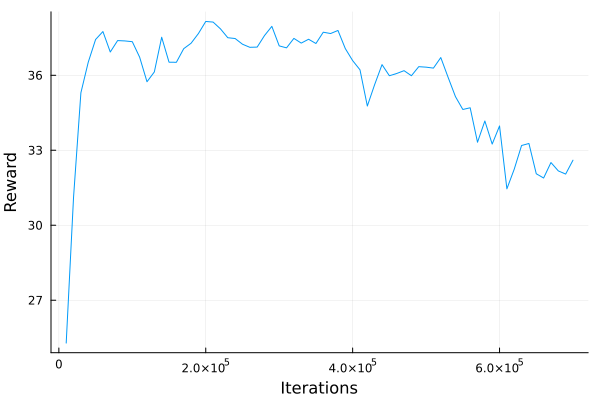

In [45]:
plot([1:num_model] * 10000, rewards, xlabel="Iterations", ylabel="Reward", legend = false, xformatter = :scientific)

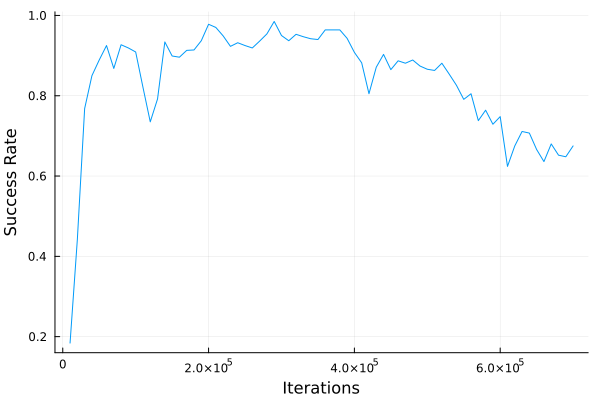

In [46]:
plot([1:num_model] * 10000, success_rate, xlabel="Iterations", ylabel="Success Rate", legend = false, xformatter = :scientific)

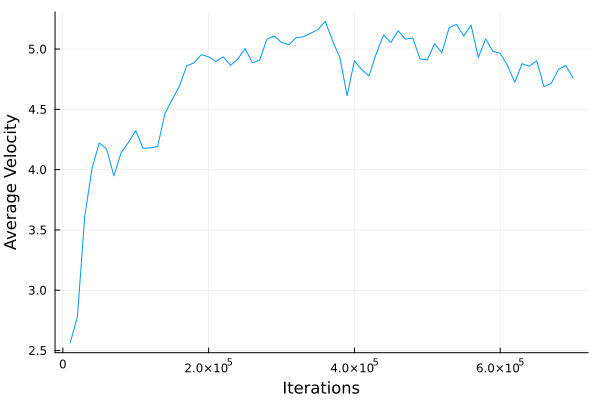

In [47]:
plot([1:num_model] * 10000, avg_velocity, xlabel="Iterations", ylabel="Average Velocity", legend = false, xformatter = :scientific)

done